# CH 6: Tools for a Customer Outreach Campaign

In this lesson, you will learn more about Tools. You'll focus on three key elements of Tools:
- Versatility
- Fault Tolerance
- Caching

In [1]:
!pip install -qU crewai==0.28.8 crewai_tools==0.1.6 langchain_community==0.0.29

In [19]:
# Warning control
import warnings
warnings.filterwarnings('ignore')

In [20]:
import os
from utils import get_bedrock_client, get_haiku_config, get_sonnet_config
from langchain_community.chat_models import BedrockChat  # Changed this import
from crewai import Agent, Task, Crew

In [21]:
# import os
# from utils import get_openai_api_key

# openai_api_key = get_openai_api_key()
# os.environ["OPENAI_MODEL_NAME"] = 'gpt-3.5-turbo'


bedrock_client = get_bedrock_client()
sonnet_config = get_sonnet_config()  # Using Sonnet config

# Create BedrockChat instance for CrewAI
llm = BedrockChat(
    client=bedrock_client,
    model_id="anthropic.claude-3-sonnet-20240229-v1:0",  # Updated model ID
    streaming=True,
    model_kwargs={
        "temperature": sonnet_config["temperature"],
        "top_p": sonnet_config["top_p"],
        "max_tokens": sonnet_config["max_tokens"],
        "anthropic_version": "bedrock-2023-05-31"
    }
)

# Set model name in environment if needed
os.environ["MODEL_NAME"] = "anthropic.claude-3-sonnet-20240229-v1:0"

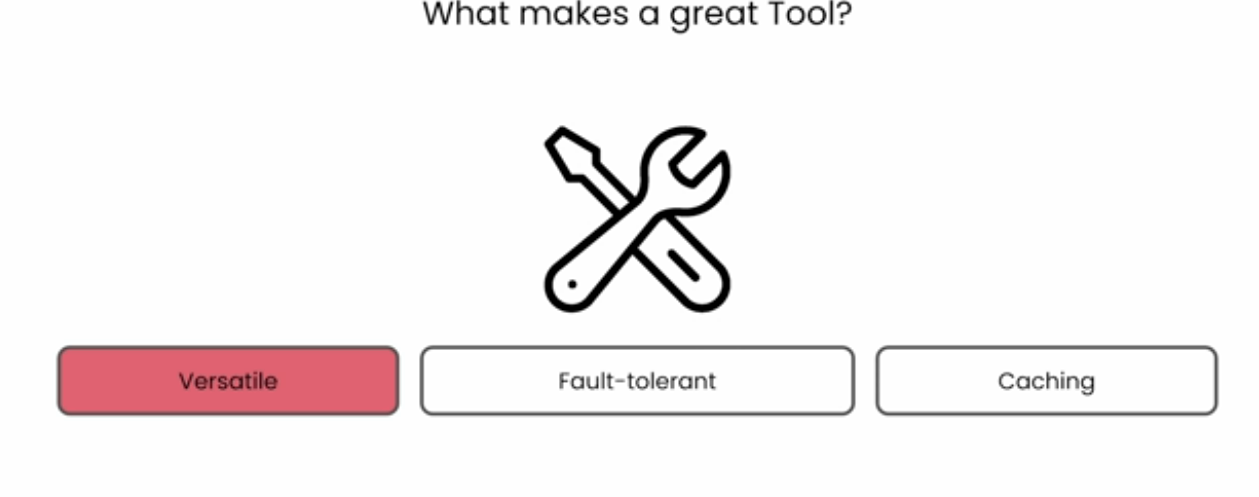

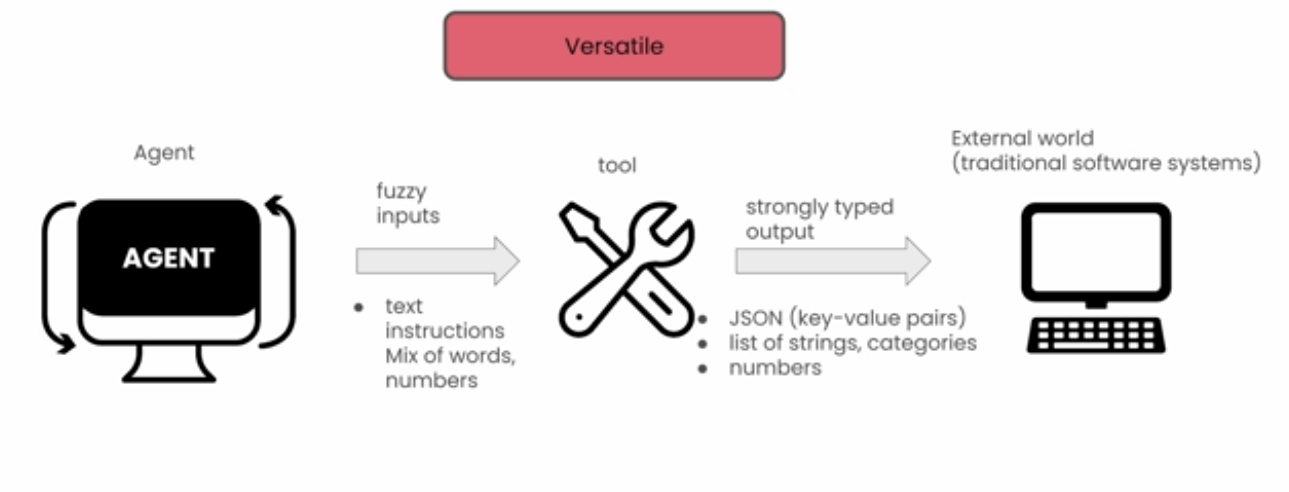

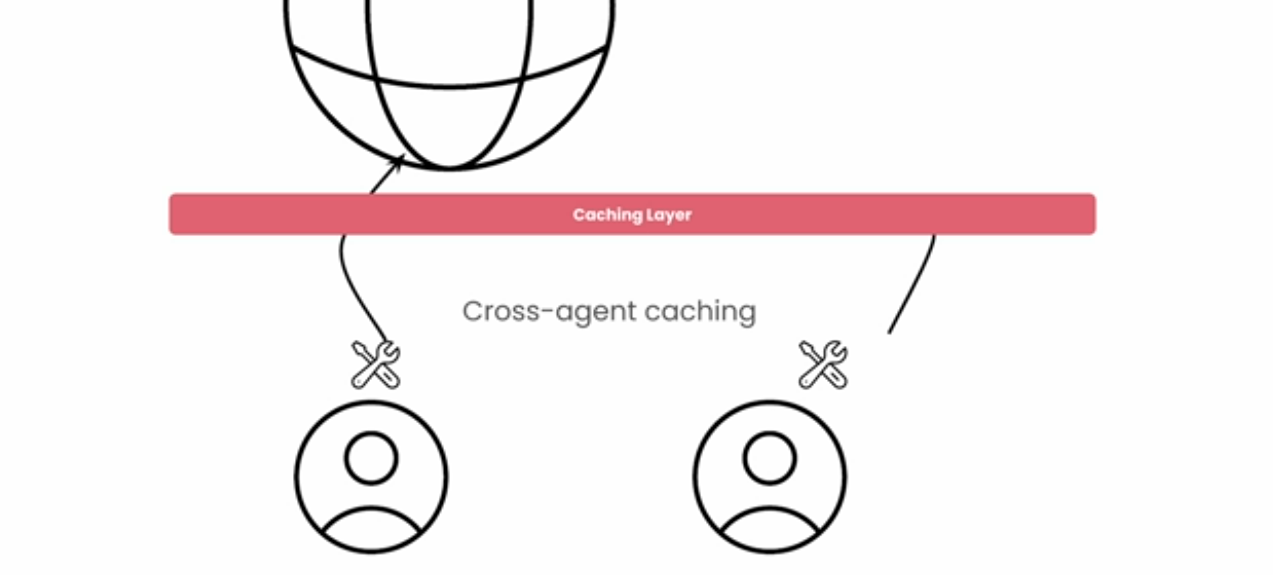

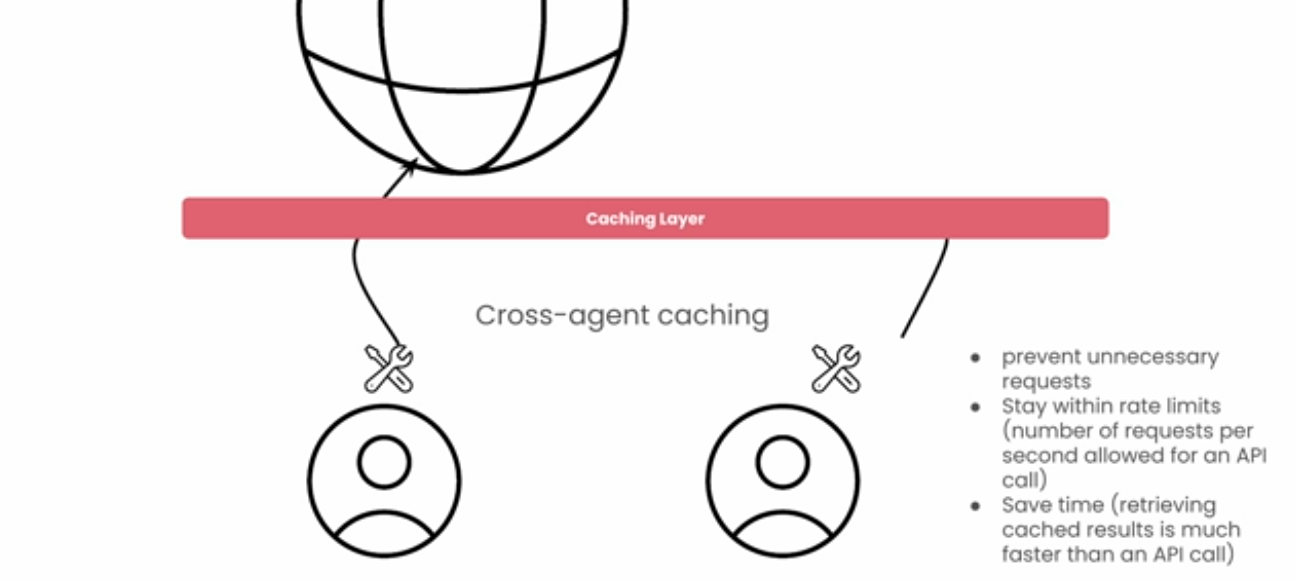

## Creating Agents

In [22]:
sales_rep_agent = Agent(
    role="Sales Representative",
    goal="Identify high-value leads that match "
         "our ideal customer profile",
    backstory=(
        "As a part of the dynamic sales team at CrewAI, "
        "your mission is to scour "
        "the digital landscape for potential leads. "
        "Armed with cutting-edge tools "
        "and a strategic mindset, you analyze data, "
        "trends, and interactions to "
        "unearth opportunities that others might overlook. "
        "Your work is crucial in paving the way "
        "for meaningful engagements and driving the company's growth."
    ),
    allow_delegation=False,
    verbose=True,
    llm=llm,
    max_iter=5,
    memory=True,
)

In [23]:
lead_sales_rep_agent = Agent(
    role="Lead Sales Representative",
    goal="Nurture leads with personalized, compelling communications",
    backstory=(
        "Within the vibrant ecosystem of CrewAI's sales department, "
        "you stand out as the bridge between potential clients "
        "and the solutions they need."
        "By creating engaging, personalized messages, "
        "you not only inform leads about our offerings "
        "but also make them feel seen and heard."
        "Your role is pivotal in converting interest "
        "into action, guiding leads through the journey "
        "from curiosity to commitment."
    ),
    allow_delegation=False,
    verbose=True,
    llm=llm,
    max_iter=5,
    memory=True,
)

## Creating Tools

### crewAI Tools

In [24]:
from crewai_tools import DirectoryReadTool, \
                         FileReadTool, \
                         SerperDevTool

In [25]:
directory_read_tool = DirectoryReadTool(directory='./instructions')
file_read_tool = FileReadTool()
search_tool = SerperDevTool()

### Custom Tool
- Create a custom tool using crewAi's [BaseTool](https://docs.crewai.com/core-concepts/Tools/#subclassing-basetool) class

In [26]:
from crewai_tools import BaseTool

- Every Tool needs to have a `name` and a `description`.
- For simplicity and classroom purposes, `SentimentAnalysisTool` will return `positive` for every text.
- When running locally, you can customize the code with your logic in the `_run` function.

In [27]:
class SentimentAnalysisTool(BaseTool):
    name: str ="Sentiment Analysis Tool"
    description: str = ("Analyzes the sentiment of text "
         "to ensure positive and engaging communication.")
    
    def _run(self, text: str) -> str:
        # Your custom code tool goes here
        return "positive"

In [28]:
sentiment_analysis_tool = SentimentAnalysisTool()

## Creating Tasks

- The Lead Profiling Task is using crewAI Tools.

In [29]:
lead_profiling_task = Task(
    description=(
        "Conduct an in-depth analysis of {lead_name}, "
        "a company in the {industry} sector "
        "that recently showed interest in our solutions. "
        "Utilize all available data sources "
        "to compile a detailed profile, "
        "focusing on key decision-makers, recent business "
        "developments, and potential needs "
        "that align with our offerings. "
        "This task is crucial for tailoring "
        "our engagement strategy effectively.\n"
        "Don't make assumptions and "
        "only use information you absolutely sure about."
    ),
    expected_output=(
        "A comprehensive report on {lead_name}, "
        "including company background, "
        "key personnel, recent milestones, and identified needs. "
        "Highlight potential areas where "
        "our solutions can provide value, "
        "and suggest personalized engagement strategies."
    ),
    tools=[directory_read_tool, file_read_tool, search_tool],
    agent=sales_rep_agent,
)

- The Personalized Outreach Task is using your custom Tool `SentimentAnalysisTool`, as well as crewAI's `SerperDevTool` (search_tool).

In [30]:
personalized_outreach_task = Task(
    description=(
        "Using the insights gathered from "
        "the lead profiling report on {lead_name}, "
        "craft a personalized outreach campaign "
        "aimed at {key_decision_maker}, "
        "the {position} of {lead_name}. "
        "The campaign should address their recent {milestone} "
        "and how our solutions can support their goals. "
        "Your communication must resonate "
        "with {lead_name}'s company culture and values, "
        "demonstrating a deep understanding of "
        "their business and needs.\n"
        "Don't make assumptions and only "
        "use information you absolutely sure about."
    ),
    expected_output=(
        "A series of personalized email drafts "
        "tailored to {lead_name}, "
        "specifically targeting {key_decision_maker}."
        "Each draft should include "
        "a compelling narrative that connects our solutions "
        "with their recent achievements and future goals. "
        "Ensure the tone is engaging, professional, "
        "and aligned with {lead_name}'s corporate identity."
    ),
    tools=[sentiment_analysis_tool, search_tool],
    agent=lead_sales_rep_agent,
)

## Creating the Crew

In [31]:
crew = Crew(
    agents=[sales_rep_agent, 
            lead_sales_rep_agent],
    
    tasks=[lead_profiling_task, 
           personalized_outreach_task],
	
    verbose=2,
	# memory=True
)

2025-01-01 12:26:43,061 - 139813624170304 - __init__.py-__init__:537 - WARNING: Overriding of current TracerProvider is not allowed


## Running the Crew

**Note**: LLMs can provide different outputs for they same input, so what you get might be different than what you see in the video.

In [33]:
inputs = {
    "lead_name": "DeepLearningAI",
    "industry": "Online Learning Platform",
    "key_decision_maker": "Andrew Ng",
    "position": "CEO",
    "milestone": "product launch"
}

result = crew.kickoff(inputs=inputs)

 [DEBUG]: == Working Agent: Sales Representative
 [INFO]: == Starting Task: Conduct an in-depth analysis of DeepLearningAI, a company in the Online Learning Platform sector that recently showed interest in our solutions. Utilize all available data sources to compile a detailed profile, focusing on key decision-makers, recent business developments, and potential needs that align with our offerings. This task is crucial for tailoring our engagement strategy effectively.
Don't make assumptions and only use information you absolutely sure about.


> Entering new CrewAgentExecutor chain...
Thought: To gather information about DeepLearningAI and compile a comprehensive report, I should first check if there are any relevant files in the directory that could provide insights.

Action: List files in directory
Action Input: {}
 

File paths: 
-./instructions/enterprise_solutions_framework.md
- ./instructions/small_business_engagement.md
- ./instructions/tech_startups_outreach.md

Thought: The fi

- Display the final result as Markdown.

In [34]:
from IPython.display import Markdown
Markdown(result)

Subject Line: Empowering Your AI Journey with CrewAI Solutions

Dear [Decision Maker's Name],

As a leader in the field of deep learning and artificial intelligence, DeepLearningAI has consistently pushed the boundaries of innovation. Your recent [product/service launch] has once again demonstrated your commitment to advancing the industry and providing cutting-edge solutions to your clients.

At CrewAI, we share your passion for leveraging the power of AI to drive transformative change. Our suite of AI-powered solutions is designed to complement and enhance your offerings, enabling you to deliver even greater value to your customers.

[Highlight specific CrewAI solutions relevant to DeepLearningAI's focus areas]

Our team of experts is dedicated to understanding your unique challenges and tailoring our solutions to meet your specific needs. We believe that by combining our strengths, we can unlock new possibilities and create a lasting impact in the AI ecosystem.

I would welcome the opportunity to discuss how our solutions can support your goals and contribute to your continued success. Please let me know if you would be interested in exploring a potential partnership or if you have any questions.

Thank you for your time, and I look forward to the possibility of working together.

Best regards,
[Your Name]
Lead Sales Representative, CrewAI

[Subsequent follow-up emails can be tailored further once more specific information about DeepLearningAI's needs, challenges, and company culture is available.]

Thought: While this template lacks specific personalization due to the limited information available, it sets the foundation for a potential partnership by highlighting our solutions' alignment with DeepLearningAI's focus areas and expressing a genuine interest in understanding their unique needs. Once more details are gathered, the messaging can be refined to resonate more deeply with their company culture and recent achievements.